# Imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

# Helpers

In [2]:
def generate_random_numbers(a, b, N, dtype, device):
    random_numbers = torch.cat([torch.tensor([0.]), a + (b - a) * torch.rand(N-1)]).view(-1, 1)
    return torch.tensor(random_numbers,
                        device=device,
                        dtype=dtype,
                        requires_grad=True)

## Data

In [3]:
class Data():
    def __init__(self, device='cpu', dtype=torch.float32):
        self.device = device
        self.dtype = dtype

    def sample_random_data(self, a, b, Nx):
        return generate_random_numbers(a, b, Nx, dtype, device)

## Model

In [4]:
class FeedForward(nn.Module):
  def __init__(self,
               n_layers,
               layers,
               activation=nn.ReLU(),
               device='cpu'):

    super().__init__()
    self.n_layers = n_layers
    self.layers = layers
    self.activation = activation

    dense_layers = [
        self.dense_layer(in_features=self.layers[i],
                         out_features=self.layers[i+1])
        for i in range(self.n_layers-1)]
    dense_layers.append(nn.Linear(in_features=self.layers[-2],
                                  out_features=self.layers[-1]))

    self.feed_forward = nn.Sequential(*dense_layers).to(device)

  def dense_layer(self, in_features, out_features):
    dense_layer = nn.Sequential(
      nn.Linear(in_features=in_features,
                out_features=out_features),
      self.activation,
    )
    return dense_layer

  def forward(self, x):
    return self.feed_forward(x)

## PINN

In [5]:
class PINN():
  def __init__(self,
               x0, u0, z0,
               Nx_initial,
               Nx_resample,
               N_top_errors,
               max_points,
               layers,
               n_layers,
               loss_coeff=1000,
               chkpt_path='model.pth',
               lr=1e-3,
               weight_decay=0,
               activation=nn.Tanh(),
               dtype=torch.float32,
               device='cpu'):

    super().__init__()

    # Some constants
    self.chkpt_path = chkpt_path
    self.device = device
    self.dtype = dtype
    self.loss_coeff = loss_coeff
    self.v = torch.tensor(13*np.pi**2, dtype=dtype, device=device)
    self.Nx_initial = Nx_initial
    self.Nx_resample = Nx_resample
    self.max_points = max_points
    self.N_top_errors = N_top_errors

    # Data
    self.data = Data(device, dtype)
    self.x = self.data.sample_random_data(0, 1, Nx_initial)
    self.x0 = torch.tensor(x0, dtype=dtype, device=device, requires_grad=True)
    self.u0 = torch.tensor(u0, dtype=dtype, device=device)
    self.z0 = torch.tensor(z0, dtype=dtype, device=device)

    # Neural network
    self.feed_forward = FeedForward(n_layers=n_layers,
                                    layers=layers,
                                    activation=activation,
                                    device=self.device)

    # Setting optimizer and scheduler
    self.optimizer = torch.optim.Adam(lr=lr,
                                      params=self.feed_forward.parameters(),
                                      weight_decay=weight_decay)

  def calculate_u(self, x):
    return self.feed_forward(x)

  def calculate_f(self, x):
    u = self.calculate_u(x)

    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    f_hat = u_x + self.v * u
    return u[0], u_x[0], f_hat

  def loss_fn(self):
    u0_hat, z0_hat, f_hat = self.calculate_f(self.x.view(-1, 1))
    loss = torch.mean(f_hat ** 2) + self.loss_coeff * ((self.u0 - u0_hat) ** 2 + (self.z0 - z0_hat) ** 2)
    return f_hat, loss

  def train_step(self):
    self.feed_forward.train()
    pde_res, batch_loss = self.loss_fn()
    loss = batch_loss.item()
    self.optimizer.zero_grad()
    batch_loss.backward()
    self.optimizer.step()
    return pde_res, loss

  def train(self, epochs, patience, print_every=1):
    t0 = pd.Timestamp.now()

    losses = list()
    for epoch in tqdm(range(epochs)):
    #   print(f"shape(x) = {self.x.shape}")
      flag = 0

      if epoch != 0:
        self.x_resample = self.data.sample_random_data(0, 1, self.Nx_initial)

        if self.x.shape[0] < self.max_points:
          x_copy = self.x.clone().detach().cpu().numpy()
          pde_abs_errors = np.abs(pde_res.clone().detach().cpu().numpy()).reshape(-1, 1)

        #   print(f"shape(x_copy) = {x_copy.shape}")
        #   print(f"shape(pde_abs_errors) = {pde_abs_errors.shape}")

          results = np.concatenate((x_copy, pde_abs_errors), axis=1)
          results_df = pd.DataFrame(results, columns=['x', 'pde_res'])

          x_min, x_max = self.define_sub_interval(results_df)
        #   while x_min == x_max:
        #     x_min, x_max = self.define_sub_valid_interval(results_df)

          x_new = self.data.sample_random_data(x_min, x_max, self.Nx_resample)
          x_new_pr = x_new.clone() if epoch == 1 else torch.cat((x_new, x_new_pr), dim=0).clone()

          self.x = torch.cat((self.x_resample, x_new_pr), dim=0)

      pde_res, loss = self.train_step()
      losses.append(loss)

      if epoch == 0:
        best_val_loss = loss
        best_epoch = -1
        self.checkpoint()
        flag = 1
        print(f"Epoch: {epoch+1}/{epochs} | Loss: {loss}- *Checkpoint*")
      else:
        if loss < best_val_loss:
          best_val_loss = loss
          best_epoch = epoch
          self.checkpoint()
          flag = 1
          if epoch % print_every == 0:
            print(f"Epoch: {epoch+1}/{epochs} | Loss: {loss} - *Checkpoint*")
        elif epoch - best_epoch > patience:
          if epoch % print_every == 0:
            print(f"\nEarly stopping applied at epoch {epoch}.")
          break
      if (flag == 0) and (epoch % print_every == 0):
        print(f"Epoch: {epoch+1}/{epochs} | Loss: {loss}")

    print(f"\nTOTAL TRAINING TIME: ")
    self.timer(t0, pd.Timestamp.now())

    return losses


  def define_sub_interval(self, results_df):
    # Sort DataFrame by the absolute PDE-errors and keep 'N_top_errors'
    results_df.sort_values(by='pde_res', ascending=False, inplace=True)
    top_errors_df = results_df.head(self.N_top_errors)

    # Extract the rectangle with the greatest test errors
    x_min, x_max = top_errors_df['x'].min(), top_errors_df['x'].max()

    return x_min, x_max

  def checkpoint(self):
    torch.save({
      "optimizer": self.optimizer.state_dict(),
      "model": self.feed_forward.state_dict()
    }, self.chkpt_path)

  def timer(self, start, end):
    dt = pd.Timedelta(end - start)
    seconds = dt.seconds
    minutes = seconds / 60.
    hours = seconds / 3600.
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

  def predict(self, x):
    t0 = datetime.now()
    x = torch.tensor(x[:, 0], dtype=self.dtype, device=self.device, requires_grad=True).float()
    self.feed_forward.eval()
    u = self.calculate_u(x.view(-1, 1))
    f, _, _ = self.calculate_f(x.view(-1, 1))
    u = u.detach().cpu().numpy()
    f = f.detach().cpu().numpy()
    print(f"TOTAL INFERENCE TIME: ")
    self.timer(t0, datetime.now())
    return u, f

# Train

In [11]:
# Data
x0 = torch.tensor([0.])
u0 = torch.tensor([1.])
z0 = torch.tensor([-13*np.pi**2])

Nx_initial = 1_000
Nx_resample = 100
N_top_errors = 1000
max_points = 20_000

# Training
epochs = 50_000
patience = 10_000
layers = [1] + 6 * [20] + [1]
n_layers = len(layers) - 1
activation = nn.ReLU()
lr = 1e-4
weight_decay = 0
loss_coeff = 1_000


# Other
path = "model.pth"
dtype = torch.float32
device = "cuda" if torch.cuda.is_available() else "cpu"
print_every = 100

pinn = PINN(
    x0, u0, z0,
    Nx_initial,
    Nx_resample,
    N_top_errors,
    max_points,
    layers,
    n_layers,
    loss_coeff=loss_coeff,
    chkpt_path=path,
    lr=lr,
    weight_decay=weight_decay,
    activation=activation,
    dtype=dtype,
    device=device
)

losses = pinn.train(epochs=epochs, patience=patience, print_every=100)

  0%|          | 0/50000 [00:00<?, ?it/s]

Epoch: 1/50000 | Loss: 16464966.0- *Checkpoint*
Epoch: 101/50000 | Loss: 16463165.0
Epoch: 201/50000 | Loss: 16461347.0
Epoch: 301/50000 | Loss: 16460386.0
Epoch: 401/50000 | Loss: 16453474.0
Epoch: 501/50000 | Loss: 16433985.0
Epoch: 601/50000 | Loss: 16369219.0
Epoch: 701/50000 | Loss: 16088336.0 - *Checkpoint*
Epoch: 801/50000 | Loss: 15287037.0 - *Checkpoint*
Epoch: 901/50000 | Loss: 13432270.0 - *Checkpoint*
Epoch: 1001/50000 | Loss: 10398131.0 - *Checkpoint*
Epoch: 1101/50000 | Loss: 6474607.5 - *Checkpoint*
Epoch: 1201/50000 | Loss: 2730759.75 - *Checkpoint*
Epoch: 1301/50000 | Loss: 1371780.0
Epoch: 1401/50000 | Loss: 214968.265625
Epoch: 1501/50000 | Loss: 15775.77734375
Epoch: 1601/50000 | Loss: 20.446739196777344
Epoch: 1701/50000 | Loss: 1.0489170551300049 - *Checkpoint*
Epoch: 1801/50000 | Loss: 26293.79296875
Epoch: 1901/50000 | Loss: 233.41346740722656
Epoch: 2001/50000 | Loss: 1.2390855550765991
Epoch: 2101/50000 | Loss: 0.9720574021339417
Epoch: 2201/50000 | Loss: 0.81

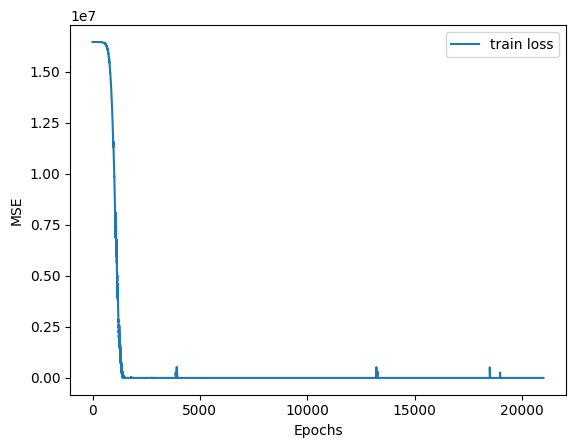

In [30]:
plt.figure()
plt.plot(losses, label='train loss')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

TOTAL INFERENCE TIME: 
00:00:00.00
Test NMSE: 0.007201324217021465


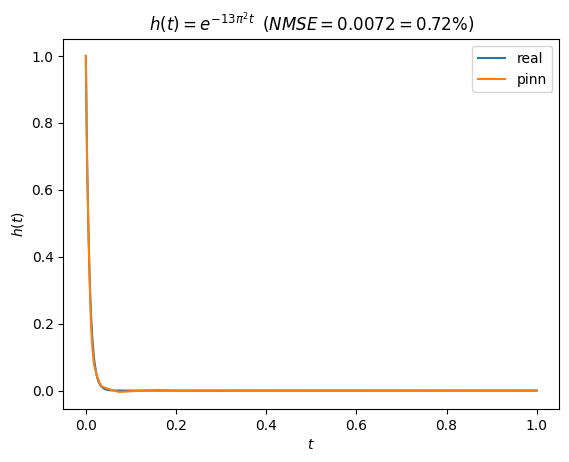

In [28]:
checkpoint = torch.load("model.pth")
pinn.feed_forward.load_state_dict(checkpoint['model'])

# PINN inference
u_hat, gv_hat = pinn.predict(pinn.x)
u_hat = u_hat.flatten()

x = pinn.x.detach().cpu().numpy()

# Real solution
u = np.exp(-pinn.v.cpu().numpy() * x).flatten()

# Calculate NMSE (Normalized Mean Square Error)
test_error = u_hat - u
test_nmse = np.linalg.norm(test_error, 2) / np.linalg.norm(u, 2)
print(f'Test NMSE: {test_nmse}')

results_df = pd.DataFrame(
    {
        "x": x.flatten(),
        "u_real": u,
        "u_pinn": u_hat
    }
)

results_df.sort_values(by='x', inplace=True)

plt.figure()
plt.plot(results_df['x'].values, results_df['u_real'].values, label='real')
plt.plot(results_df['x'].values, results_df['u_pinn'].values, label='pinn')
plt.xlabel(r"$t$")
plt.ylabel(r"$h(t)$")
plt.title(r"$h(t) = e^{-13\pi^2 t} \;\; (NMSE = 0.0072 = 0.72\%)$")
plt.legend()
plt.show()

In [29]:
results_df.to_csv("h_results.csv")